In [41]:
import re
import numpy as np
import time
import requests
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt, rcParams
import pandas as pd
#from pydataset import data as dt
from matplotlib import pyplot as plt

% matplotlib inline

# Introduction

My goal is to identify conditions that may cause or be in some way connected to depression. I analyzed data from the National Health and Nutrition Examination Survey (NHANES). This survey contains responses to demographic, socioeconomic, dietary, and mental health related questions (as well as results from many other tests). NHANES conducts these surveys each year so I had many years of data to use. This data set also contains responses to questions relating to almost all aspects of a personal health history. This was useful in finding all possible relationships with depression and other personal conditions. 

Although the exact cause of most mental illnesses is not known, it is becoming clear through research that many of these conditions are caused by a combination of genetic, biological, psychological, and environmental factors. A study by the mayo clinic confirmed these results. The research resulting in this conclusion was done through cross-sectional surveys and longitudinal-studies. 

# Data Collection

#### Gathering Data
The data was available on https://kaggle.com in csv form. The original data is from https://wwwn.cdc.gov/nchs/nhanes/Default.aspx. I loaded all the csv files and merged the data into a single data frame sorted by sequence number. This data has results from surveying 9813 people on 1812 different questions. 

In [48]:
all_data = {}

# get data from data files
data_files = ["demographic","diet","examination", "labs", "questionnaire"]
for filename in data_files:
    data = pd.read_csv(filename + ".csv")
    all_data[filename] = data

# combine all data into single data frame
data = pd.merge(all_data[data_files[0]],all_data[data_files[1]],on="SEQN")
for j in range(2,len(data_files)):
    data = pd.merge(data,all_data[data_files[j]])

#### Organizing Data
The variable names in the data were extremely ambiguous so I scraped descriptions for the variable names from NHANES official site (centers for disease control and prevention). I also filtered the variable names and created a list of unwanted columns to drop from the dataframe. 

In [43]:
def get_variable_info():
    """
    Crawl through the NHANES site to get variable 
    names and descriptions for data.
    """
    
    variable_info = {}
    to_keep = []
    
    # these are the variables that we are interested in analysing
    to_keep_list = ['URXUMA','DED125','ALQ120Q','ALQ120U',
                    'URXUMS','URXCRS','URDACT','LBXTC','LBXWBCSI',
                    'LBXRBCSI','LBXHGB','LBXPLTSI','LBXSCH','LBXSCA',
                    'LBXSGL','LBXSIR','RIAGENDR','RIDAGEYR',
                    'DMDCITZN','DMDEDUC2','DMDMARTL',
                    'RIDEXPRG','INDFMIN2','INDFMPIR','DMDFMSIZ',
                    'RIDRETH3','DMDHHSZA','DMDHHSZB',
                    'DMDHHSZE','DUQ240','MCQ220','BMXWAIST','BMXBMI',
                    'BMXHT','BMXWT','BPXPLS','BPXSY3','BPXSY2',
                    'BPXDI3','BPXDI2','DBD100','DRQSPREP','DRQSDIET',
                    'RHQ420','RHQ540','SXD021','SLD010H','OCQ180',
                    'SMQ020','WHD020','WHD050','WHD030','WHD070',
                    'DAQ665','PAD680','PAQ710','PAQ715']
    to_keep_re = re.compile('^DPQ[0-9]{3}$')
    
    datatype_finder = re.compile(r"^(Demographics|Dietary|Examination|Laboratory|Questionnaire)$")
    varpage_finder = re.compile(r"^NHANES 2013-2014.*Variable List$")
    the_base = "https://wwwn.cdc.gov"
    base_url = "https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2013"      
    base_soup = BeautifulSoup(requests.get(base_url).text, "html.parser")
    page_tags = base_soup.find_all(name='a', href=True, string=datatype_finder)
    pages = [the_base + tag.attrs["href"] for tag in page_tags]
    
    for page in pages:
        variable_names = []
        variable_descriptions = []
        end = page.find('&')
        key = page[64:end]
        time.sleep(1)           
        soup = BeautifulSoup(requests.get(page).text, "html.parser")
        new_base = the_base + "/nchs/nhanes/search/"
        next_page = new_base + soup.find_all(name="a", string=varpage_finder, href=True)[0].attrs["href"]
        
        time.sleep(1)
        new_soup = BeautifulSoup(requests.get(next_page).text, "html.parser")
        names = new_soup.find_all(name="tr")[2:]

        for name in names:
            temp = name.find_all(name="td")
            varname = temp[0].text
            desc = temp[1].text
            
            if varname in to_keep_list or re.search(to_keep_re, varname):
                to_keep.append(varname)
                variable_info[varname] = desc
            
    return variable_info, to_keep

var_info, to_keep = get_variable_info()

#### Feature Engineering

    Dropping unwanted data from table.
    Replacing multiple blood pressure data columns with single average.
    Adjusting alcohol consumption to account for different units.
    Replace data with previous year's weight with data representing weight gained in last year.
    Creating separate dataframes with variables only pertaining to women (drop these variables from main data frame).
    Eliminating rows of table that have NaN for at least 20 of the columns.
    
The resulting dataframe now has only 57 columns.


In [49]:
# generate drop list from list of variables to keep and drop unwanted
drop_list = [c for c in data.columns if c not in to_keep]
data.drop(drop_list,axis=1, inplace=True)

# set general unanswered questions to NaN as to no scew data
# the numbers 77,777,7777,77777,99,999,9999,99999 represent unanswered questions
# setting these numbers to NaN will prevent inaccurate outliers from appearing in the data
data[(data == 777.0) | (data == 999.0) | (data == 77.0) | (data == 99.0) | (data == 7777.0) | (data == 9999.0) | (data == 77777.0) | (data == 99999.0)] = np.nan

# average blood pressure data and replace with averages
data['BPXSY'] = data[['BPXSY3','BPXSY2']].mean(axis=1)
data['BPXDI'] = data[['BPXDI3','BPXDI2']].mean(axis=1)
data.drop(['BPXSY3','BPXSY2','BPXDI3','BPXDI2'], axis=1, inplace=True)
var_info['BPXSY'] = 'Systolic:  Blood pressure mm Hg'
var_info['BPXDI'] = 'Diastolic: Blood pressure mm Hg'

# adjust alcohol consumption data for different units
data[['ALQ120Q','ALQ120U']]
units = {1:(1/7),2:(12/365),3:(1/365)}
data = data.replace({'ALQ120U':units})
data['ALQ120'] = data['ALQ120Q'].multiply(data['ALQ120U'], axis='index')
data.drop(['ALQ120Q','ALQ120U'], axis=1, inplace=True)
var_info['ALQ120'] = 'Number of times alcohol is consumed per day'

# create column corresponding to weight gained in last year
# remove column corresponding to previous year's weight
data['WHD0250'] = data[['WHD020']].sub(data['WHD050'], axis='index')
var_info['WHD0250'] = 'Weight gained in the last year'
data.drop(['WHD050','WHD020'], axis=1, inplace=True)

# combine column with amount of time spent on computer with column with time spent on TV
# this will create one column that represents the amount of 'screen' time
data['PAQ700'] = data['PAQ710'] + data['PAQ715']
data.drop(['PAQ710','PAQ715'], axis=1, inplace=True)

# create separate data frame containing data relating to pregnancy
women_ = re.compile(r'^(RIDEXPRG|RHQ)')
mental_ = re.compile(r'^DPQ')
colw = [c for c in data.columns if re.match(women_, c) or re.match(mental_, c)]
women = data[colw].dropna()
temp = women[colt]
temp[temp > 2.0] = np.nan
women[colt] = temp
colt = [c for c in data.columns if re.match(women_, c)]
data.drop(colt, axis=1, inplace=True)

# drop rows that have NaN for at least 20 columns
null_count = data.isnull().sum(axis=1)
data = data[null_count <= 20]

# set unanswered questions regarding mental health to NaN
mental_health = ['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050', 'DPQ060','DPQ070','DPQ080','DPQ090']
temp = data[mental_health]
temp[temp > 4.0] = np.nan
data[mental_health] = temp

data

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

,RIAGENDR,RIDAGEYR,RIDRETH3,DMDCITZN,DMDEDUC2,DMDMARTL,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,...,OCQ180,PAD680,SLD010H,SMQ020,SXD021,BPXSY,BPXDI,ALQ120,WHD0250,PAQ700
0,1,69.0,4,1.0,3.0,4.0,3,0,0,2,...,NaN,600.0,7.0,1.0,1.0,108.0,75.0,0.002740,-30.0,10.0
1,1,54.0,3,1.0,3.0,1.0,4,0,2,0,...,50.0,540.0,9.0,1.0,1.0,158.0,61.0,1.000000,40.0,12.0
2,1,72.0,3,1.0,4.0,1.0,2,0,0,2,...,NaN,300.0,8.0,1.0,NaN,143.0,78.0,NaN,0.0,4.0
4,2,73.0,3,1.0,5.0,1.0,2,0,0,2,...,NaN,480.0,9.0,2.0,NaN,138.0,87.0,NaN,-30.0,2.0
5,1,56.0,1,1.0,4.0,3.0,1,0,0,0,...,56.0,360.0,5.0,1.0,1.0,156.0,81.0,0.013699,-5.0,13.0
7,2,61.0,3,1.0,5.0,2.0,1,0,0,1,...,NaN,60.0,9.0,2.0,1.0,125.0,81.0,0.005479,0.0,0.0
8,2,56.0,3,1.0,3.0,3.0,7,3,0,0,...,38.0,30.0,6.0,1.0,1.0,119.0,72.0,0.142857,0.0,9.0
9,1,65.0,3,1.0,2.0,2.0,1,0,0,1,...,20.0,480.0,7.0,1.0,1.0,142.0,77.0,0.571429,0.0,3.0
10,2,26.0,3,1.0,5.0,5.0,3,0,0,0,...,40.0,600.0,8.0,2.0,2.0,104.0,64.0,0.285714,-5.0,8.0
12,1,76.0,3,1.0,5.0,1.0,2,0,0,2,...,NaN,600.0,6.0,2.0,NaN,128.0,68.0,0.005479,2.0,4.0


# Data Visualization
plots and analysis of the data

Plot the data in various relevant ways.
Describe clearly what these plots tell you.
Use the plots to identify outliers, bad data, etc
Use the plots to identify patterns and relations in the data.
Repeat the process as necessary to get a clear view of what is going on.

This data contains respondes to the following questions. 

Over the last 2 weeks, how often have you been bothered by the following problems:

    DPQ010 little interest or pleasure in doing things?
    DPQ020 feeling down, depressed, or hopeless?
    DPQ030 trouble falling or staying asleep, or sleeping too much?
    DPQ040 feeling tired or having little energy?
    DPQ050 poor appetite or overeating?
    DPQ060 feeling bad about yourself - or that you are a failure or have let yourself or your family down?
    DPQ070 trouble concentrating on things, such as reading the newspaper or watching TV?
    DPQ080 moving or speaking so slowly or being so figety or restless that other people could have noticed?
    DPQ090 thoughts that you would be better off dead or of hurting yourself in some way?
    
The possible responses are:

I compared the responses to these questions against all other information in the data frame and will display the more significant results below.

1 : Poverty Ratio


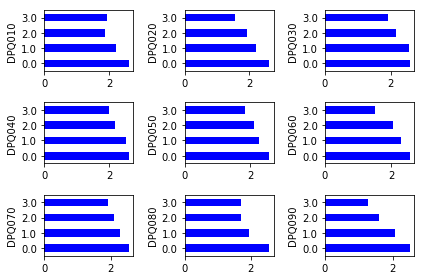

2 : Screen Time


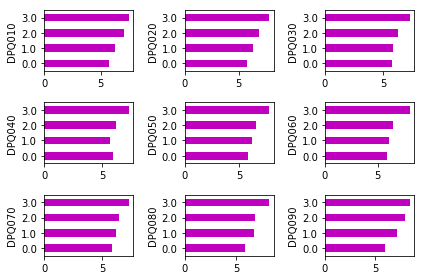

3 : BMI


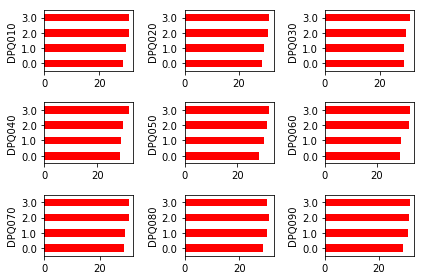

4 : Education Level


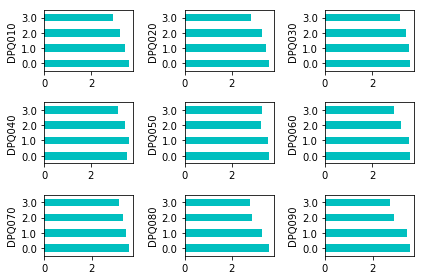

5 : Family Size


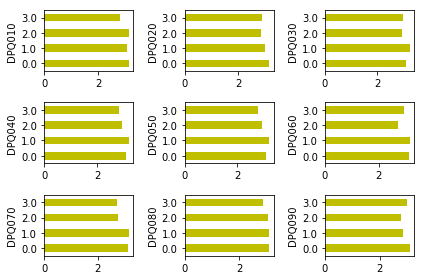

6 : Number of Children < 5


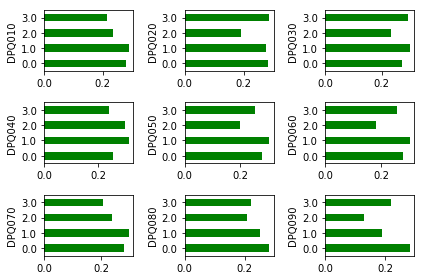

7 : Number of Children 6 - 17


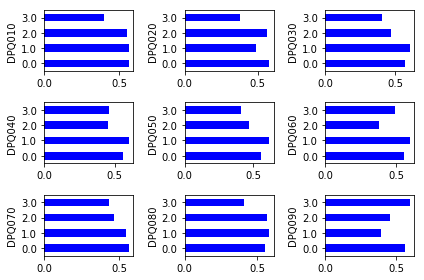

8 : Urine


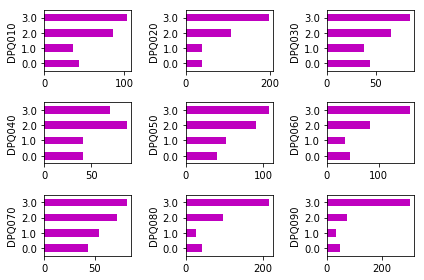

In [50]:
cool = ['INDFMPIR','PAQ700','BMXBMI','DMDEDUC2','DMDFMSIZ','DMDHHSZA','DMDHHSZB','URDACT']
titles = ['Poverty Ratio', 'Screen Time','BMI', 'Education Level', 'Family Size', 'Number of Children < 5', 'Number of Children 6 - 17', 'Urine']
colors = ['b','m','r','c','y','g','b','m','r','c','y','g']

for i in range(8):
    print(i+1,':',titles[i])
    loc = 0
    for q in mental_health:
        plt.subplot(3,3, loc+1)
        sep = data.groupby(q)
        sep[cool[i]].mean().plot(kind="barh",color=colors[i])
        plt.tight_layout()
        loc += 1

    plt.show()

#### Data Analysis

The plots above show the most significant relationships between the mental health results and other data points. 

The first plots shows the ratio of the family's income to their poverty level. Where the higher the ratio, the less the family is in poverty. 
The graphs show that there is definitely positive correlation between higher income levels and better mental health. 

The second plots shows the amount of hours spent on TV or computer each week. 
Though less significant than the poverty ratio, these plots show that there is a positive correlation between time spent on the TV and computer and poor mental health. 

The third and fourth plots show less significant relationships.
The third shows the BMI of each individual and the fourth shows the education level (2 being below high school, 3 high school, and 4 college). 
The very minimal correlation between these characteristics and mental health is also true for the graphs showing waist circumference, weight, height, race, and age (not pictures here).


The fifth, sixth, and seventh plots show data regarding the number of individuals in the household. The fifth shows there is not a relationship between household size and mental health.
But the sixth and seventh plots point to a potential (though minor) correlation between the ages of kids at home and mental health. 

The eigth plots are by far the most interesting. They show a very strong correlation between Albumin creatinine ratio in the urine and responses to mental health questions. 

INDFMPIR


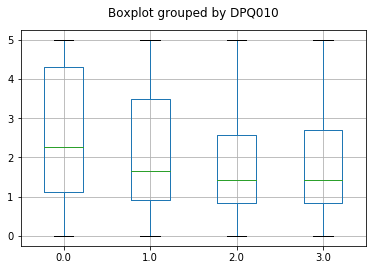

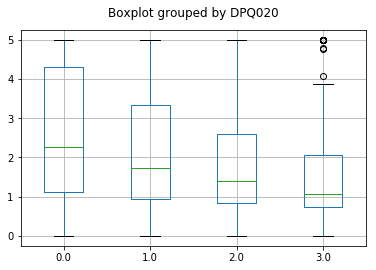

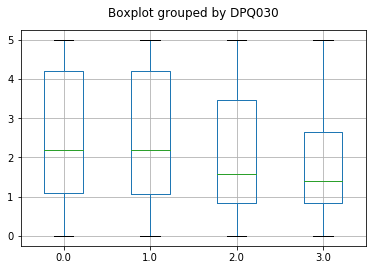

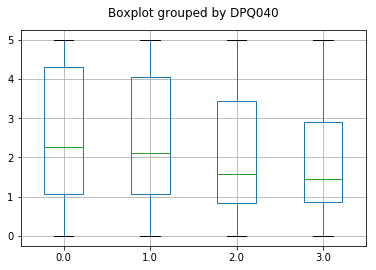

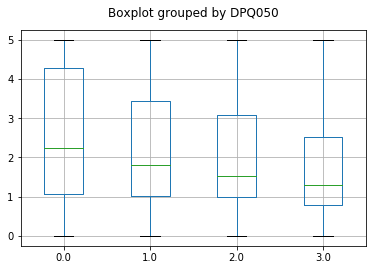

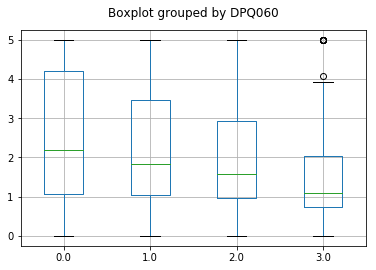

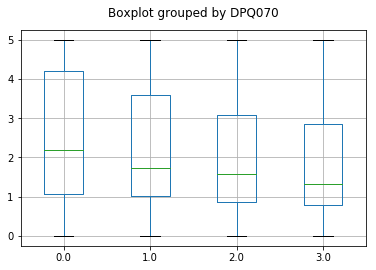

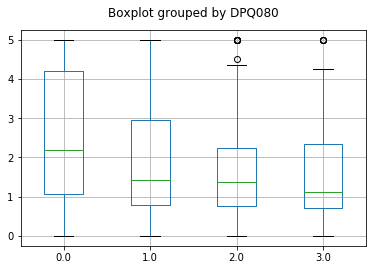

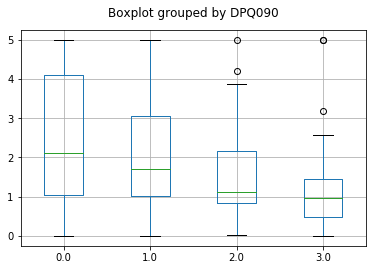

PAQ700


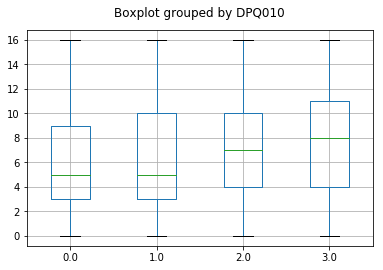

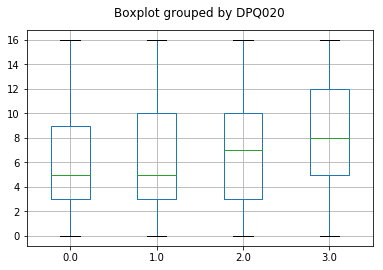

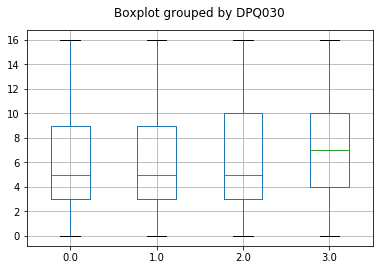

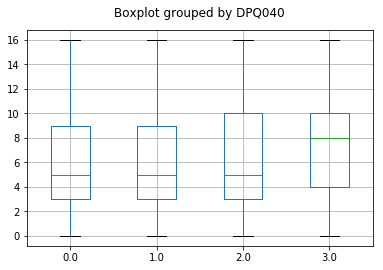

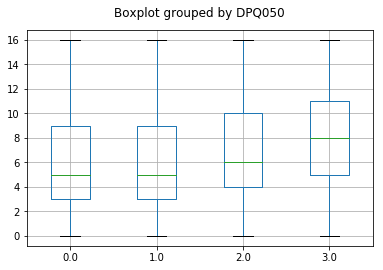

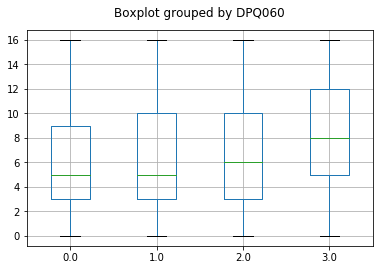

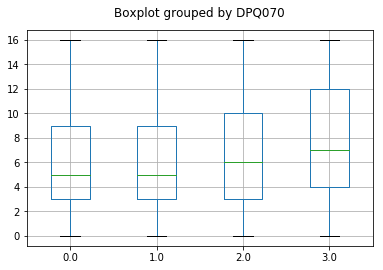

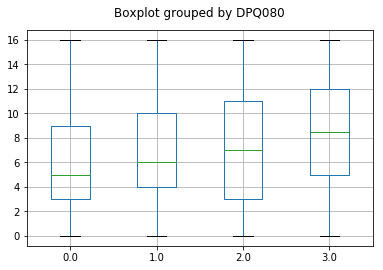

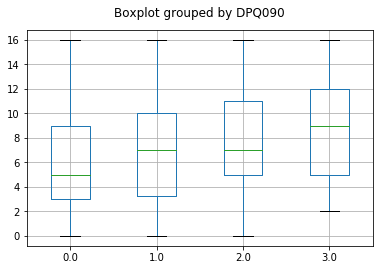

In [51]:
sig = ['INDFMPIR','PAQ700']

for i in sig:
    print(i)
    for q in mental_health:
        sep = data.groupby(q)

        data.boxplot(i, by=q)
        plt.title('')
        plt.xlabel('')
        plt.show()

### Data Analysis

The above plots give a closer look into the relationships between poverty ratio and mental health and screen time and mental health. The plots enforce the orginial observations that some sort of relationship exists though not an extremely strong one. 

Pregnant


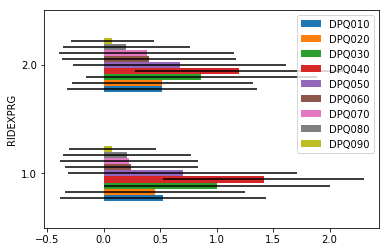

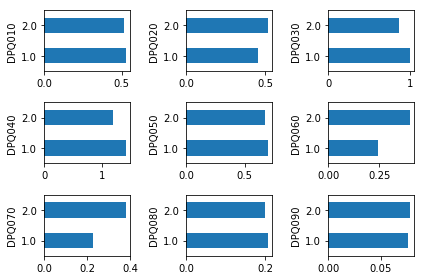

Birth Control


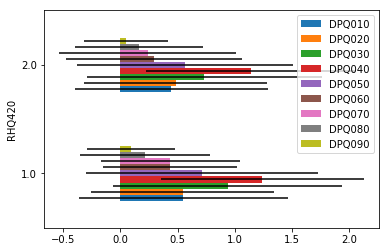

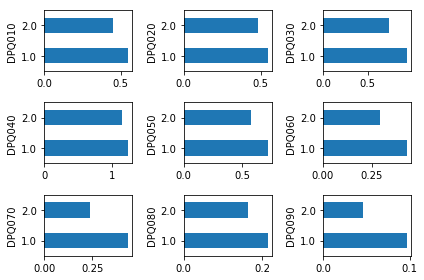

In [64]:
catagories = ['RIDEXPRG','RHQ420']
titles = ['Pregnant','Birth Control']

for i in range(2):
    print(titles[i])
    
    sub = women.groupby(catagories[i])
    sub[mental_health].mean().plot(kind="barh",xerr=preg.std())
    plt.show()

    loc = 0
    for q in mental_health:
        plt.subplot(3,3, loc+1)
        sub[q].mean().plot(kind="barh")
        plt.tight_layout()
        plt.ylabel(q)
        loc += 1
    plt.show()


The above plots show the responses to the mental health questions for women. The first two show the results split for pregnant and non-pregnant women. The last two show the results split for women on and off birth control. A 1 corresponds to either being pregnant or on birth control respectively. 

For all of the data the responses to the mental health questions are very mild. With only one graph having averages exceeding 1. But in the pregnancy data we see that pregnant women have more positive answers for questions 6 and 7. In the birth control data we see that women on birth control respond more negatively to every question. 

# Conclusion
For the most part the factors relating to mental health problems are not surprising. 